In [13]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Directories and CSV paths
CLEAN_DIR = "whale_audio_clean"
LABELS_PATH = "data/labels.csv"

# Hyperparameters for MFCC extraction
N_MFCC = 13  # Number of MFCCs
SAMPLE_RATE = 16000  # 16kHz as per previous conversion
MAX_LENGTH = 130  # Max length of audio in frames (e.g., 3 seconds for a 16kHz sample rate)

In [3]:
# Load labels
labels_df = pd.read_csv(LABELS_PATH)

In [4]:
# Preprocessing: MFCC extraction and padding/trimming
def extract_mfcc(filename):
    file_path = os.path.join(CLEAN_DIR, filename)
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        
        # Pad or trim MFCCs
        if mfcc.shape[1] < MAX_LENGTH:
            # Pad with zeros
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LENGTH - mfcc.shape[1])), mode='constant')
        else:
            # Trim to max length
            mfcc = mfcc[:, :MAX_LENGTH]

        return mfcc.T  # Transpose so that each frame is a row

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Prepare dataset
X = []
y = []

for _, row in labels_df.iterrows():
    filename = row["filename"]
    label = row["label"]
    mfcc = extract_mfcc(filename)
    if mfcc is not None:
        X.append(mfcc)
        y.append(label)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Count frequencies of encoded labels
label_counts = Counter(y_encoded)
topx_labels = [label for label, _ in label_counts.most_common(5)]
print("Top 3 label indices:", topx_labels)

# Filter X and y_encoded for top 3 labels only
X_filtered = []
y_filtered = []

for mfcc, label in zip(X, y_encoded):
    if label in topx_labels:
        X_filtered.append(mfcc)
        y_filtered.append(label)

X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)

# Remap the labels to 0, 1, 2 for classification
label_map = {old: new for new, old in enumerate(topx_labels)}
y_filtered_remapped = np.array([label_map[l] for l in y_filtered])


# First split: 90% train+val, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X_filtered, y_filtered_remapped, test_size=0.1, random_state=42, stratify=y_filtered_remapped)

# Second split: of the 90%, use 88.89% for train and 11.11% for val (i.e., 80/10/10 overall split)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset class for PyTorch
class WhaleDataset(Dataset):
    def __init__(self, mfccs, labels):
        self.mfccs = mfccs
        self.labels = labels

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        return torch.tensor(self.mfccs[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = WhaleDataset(X_train, y_train)
val_dataset = WhaleDataset(X_val, y_val)
test_dataset = WhaleDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Show a batch
for data, label in train_loader:
    print(f"Batch shape: {data.shape}, Labels: {label}")
    break

# Shape: torch.Size([32, 130, 13])
# Batches are size 32 (audio files processed at the time)
# 130 is the number of time frames
# 13 is the number of MFCC features for each time frame.

# 12 label classes: range(0-11)

Top 3 label indices: [1, 4, 11, 0, 3]
Batch shape: torch.Size([32, 130, 13]), Labels: tensor([1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 4, 1, 0, 1, 0, 2, 1, 4, 3, 0,
        1, 1, 3, 1, 2, 3, 1, 0])


# Define model

In [5]:
class WhaleAudioCNN(nn.Module):
    def __init__(self):
        super(WhaleAudioCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(64 * 65, 128)
        self.fc2 = nn.Linear(128, len(np.unique(y_train)))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 65)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = WhaleAudioCNN().to(device)
print(model)

# WhaleAudioCNN(
#   (conv1): Conv1d(13, 32, kernel_size=(3,), stride=(1,), padding=(1,))
#   (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
#   (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (fc1): Linear(in_features=4160, out_features=128, bias=True)
#   (fc2): Linear(in_features=128, out_features=12, bias=True)
# )

# Sanity check
# First layer has input dimensions per batch
# Last layer has 12 output features

Using device: cpu
WhaleAudioCNN(
  (conv1): Conv1d(13, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4160, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


# Set hyperparameters

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # You can adjust this based on your needs
train_losses = []
test_accuracies = []

# Train model

In [8]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        data = data.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.permute(0, 2, 1)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, Train Loss: 1.2861, Train Acc: 46.43%, Val Loss: 1.8913, Val Acc: 14.29%
Epoch 2, Train Loss: 0.5315, Train Acc: 79.46%, Val Loss: 1.7955, Val Acc: 21.43%
Epoch 3, Train Loss: 0.2960, Train Acc: 89.29%, Val Loss: 0.9866, Val Acc: 57.14%
Epoch 4, Train Loss: 0.3798, Train Acc: 90.18%, Val Loss: 0.5451, Val Acc: 85.71%
Epoch 5, Train Loss: 0.1273, Train Acc: 95.54%, Val Loss: 0.7177, Val Acc: 64.29%
Epoch 6, Train Loss: 0.2955, Train Acc: 90.18%, Val Loss: 0.2942, Val Acc: 92.86%
Epoch 7, Train Loss: 0.2136, Train Acc: 92.86%, Val Loss: 0.2195, Val Acc: 85.71%
Epoch 8, Train Loss: 0.0999, Train Acc: 97.32%, Val Loss: 0.1593, Val Acc: 92.86%
Epoch 9, Train Loss: 0.1731, Train Acc: 91.96%, Val Loss: 0.0939, Val Acc: 100.00%
Epoch 10, Train Loss: 0.1745, Train Acc: 95.54%, Val Loss: 0.0414, Val Acc: 100.00%
Epoch 11, Train Loss: 0.0884, Train Acc: 96.43%, Val Loss: 0.0424, Val Acc: 100.00%
Epoch 12, Train Loss: 0.1709, Train Acc: 95.54%, Val Loss: 0.1013, Val Acc: 100.00%
Epoch 13,

In [11]:
# After training is complete, create and save the plots
epochs = range(1, len(train_losses) + 1)

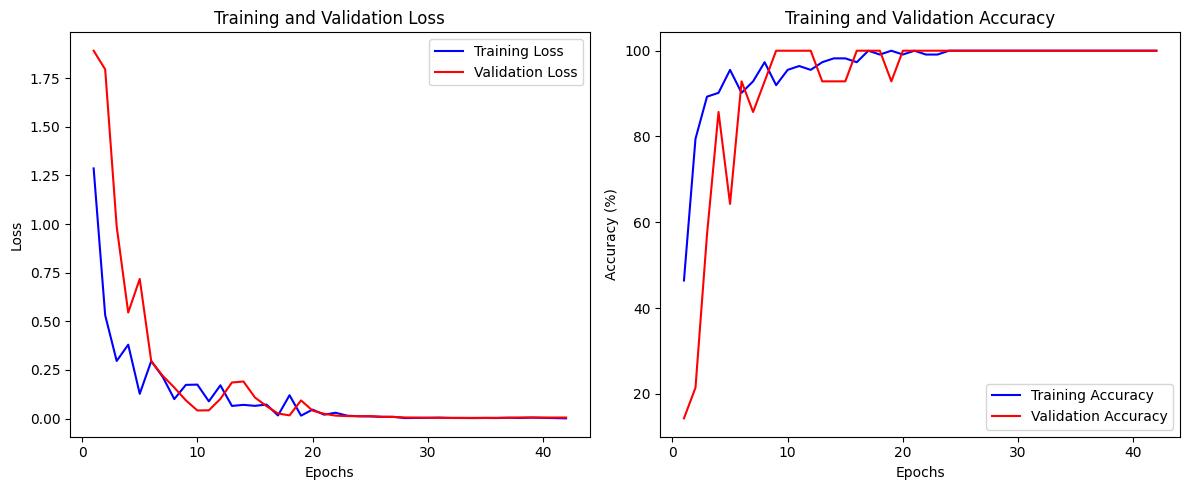

In [12]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Convert to ONNX

In [1]:
import torch
import torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import numpy as np # Make sure numpy is imported

# --- Re-define your model class here ---
# Make sure this class definition is identical to the one used during training
class WhaleAudioCNN(nn.Module):
    def __init__(self, num_classes=5): # Assuming 5 classes based on your filtering
        super(WhaleAudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2, 2)
        # Correct the flattened size calculation based on pooling
        # Input length: 130 -> After Conv1/BN1 -> 130
        # After Conv2/BN2 -> 130
        # After MaxPool1d(2, 2) -> 130 / 2 = 65
        self.flattened_size = 64 * 65 # Recalculate if model architecture changes
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.3) # Define dropout layer used in forward
        self.fc2 = nn.Linear(128, num_classes) # Use num_classes parameter

    def forward(self, x):
        # Input x expected shape: [batch_size, num_features (13), sequence_length (130)]
        x = F.relu(self.bn1(self.conv1(x)))
        # After pool, shape: [batch_size, 64, sequence_length / 2 (65)]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x) # Apply dropout
        # Flatten the output for the linear layer
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

In [2]:
# --- Conversion Script ---
# Determine the number of classes based on your filtered data (e.g., 5)
NUM_CLASSES = 5 # IMPORTANT: Set this to the actual number of classes (e.g., 5)
MODEL_PATH = "best_model.pth"
ONNX_MODEL_PATH = "whale_model.onnx"

In [4]:
# Instantiate the model
model = WhaleAudioCNN(num_classes=NUM_CLASSES)

# Load the saved state dictionary
# Make sure to map location to CPU if the model was trained on GPU
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

# Set the model to evaluation mode (important!)
model.eval()

# Define a dummy input tensor with the correct shape
# Shape: [batch_size, num_features (channels), sequence_length]
# Your model expects [batch, 13, 130] after the permute operation in your training loop
dummy_input = torch.randn(1, 13, 130, requires_grad=True)

# Define input and output names for the ONNX model (optional but recommended)
input_names = ["input_mfcc"]
output_names = ["output_logits"]

# Export the model
print(f"Exporting model to {ONNX_MODEL_PATH}...")
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  ONNX_MODEL_PATH,     # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=input_names,   # the model's input names
                  output_names=output_names, # the model's output names
                  dynamic_axes={'input_mfcc' : {0 : 'batch_size'}, # variable length axes
                                'output_logits' : {0 : 'batch_size'}})
print("Model exported successfully.")

Exporting model to whale_model.onnx...
Model exported successfully.


In [5]:
import json
import numpy as np
# Assuming 'mfcc_array' is your numpy array of shape (130, 13) for the sample audio
# mfcc_array = extract_mfcc("path/to/your/sample_whale_sound.wav") # Make sure CLEAN_DIR is correct

# --- Placeholder: Replace with your actual MFCC extraction ---
# Example: Create a dummy MFCC array if you don't have one ready
SAMPLE_RATE = 16000
MAX_LENGTH = 130
N_MFCC = 13
# Replace this with your actual extracted MFCC data for the chosen validation file
mfcc_array = np.random.rand(MAX_LENGTH, N_MFCC).astype(np.float32)
# --- End Placeholder ---


# Ensure the shape is correct
if mfcc_array is not None and mfcc_array.shape == (MAX_LENGTH, N_MFCC):
    # Convert numpy array to a list of lists for JSON serialization
    mfcc_list = mfcc_array.tolist()
    with open("sample_mfcc.json", "w") as f:
        json.dump(mfcc_list, f)
    print("Saved sample_mfcc.json")
else:
    print(f"Error: MFCC array is None or has incorrect shape. Expected ({MAX_LENGTH}, {N_MFCC})")

# Also, identify the correct label for this sample sound
# Find the corresponding label index from y_val for the chosen audio file.
# Map this index back to the actual whale species name using your label_encoder and label_map.
# For now, we'll use placeholders like 'Species 1', 'Species 2', etc.

Saved sample_mfcc.json
